# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2025-02-18 03:26:53 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × AMD EPYC 7B12
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, znver2)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


In [ ]:
using BenchmarkTools

M = rand(2^11, 2^11)

@btime $M * $M;

SyntaxError: invalid syntax (<ipython-input-6-2e10632734cc>, line 1)

In [ ]:
try
    using CUDA
catch
    println("No GPU found.")
else
    run(`nvidia-smi`)
    # Create a new random matrix directly on the GPU:
    M_on_gpu = CUDA.CURAND.rand(2^11, 2^11)
    @btime $M_on_gpu * $M_on_gpu; nothing
end

No GPU found.


# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />



================================================================================



This note to solve Aiyagari model is adopted from Tomas R. Martinez. Visit the website for detailed explanations.

https://tomasrm.github.io/teaching/quantmacro/Aiyagari_EGM_notebook.jl.html


================================================================================


#Solving Aiyagari using the Endogenous Grid Method
The goal of this note is to illustrate how to solve a standard incomplete market model (a la Aiyagari-Hugget) using the Endogenous Grid Method (EGM) and non-stochastic simulation.


#Numerical Implementation
The first step is to define the packages used in the code:

In [18]:
## ======================================================================== ##
# This block import the packages we use
## ======================================================================== ##
import Pkg; Pkg.add("Parameters")
import Pkg; Pkg.add("Distributions")
import Pkg; Pkg.add("Roots")
import Pkg; Pkg.add("PlutoUI")
import Pkg; Pkg.add("Plots")

	using Parameters # enable @unpack
	using Distributions # enable cdf of Normal
	using Roots         # root finding routines: brent
	using PlutoUI    # printing stuff in the Pluto notebook
	using Plots # plots: comment out if you wont use it, since it is heavy.


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
   Installed IOCapture ────────────── v0.2.5
   Installed HypertextLiteral ─────── v0.9.5
   Installed Tricks ───────────────── v0.1.10
   Installed Hyperscript ──────────── v0.0.4
   Installed PlutoUI ──────────────── v0.7.23
   Installed AbstractPlutoDingetjes ─ v1.3.2
    Updating `~/.julia/environments/v1.8/Project.toml`
⌃ [7f904dfe] + PlutoUI v0.7.23
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [6e696c72] + AbstractPlutoDingetjes v1.3.2
⌅ [47d2ed2b] + Hyperscript v0.0.4
  [ac1192a8] + Hypertext

The next block of codes define auxiliary functions. Tauchen and Rouwenhorst are functions used to discretize the labor process. The other two functions are used to do some fast linear interpolation.

In [4]:
## ======================================================================== ##
# Tauchen and Rouwenhorst functions
## ======================================================================== ##
begin

function tauchen(N, ρ, σ; μ = 0.0, m = 3.0)
	s1    = μ/(1-ρ) - m*sqrt(σ^2/(1-ρ^2))
   	sN    = μ/(1-ρ) + m*sqrt(σ^2/(1-ρ^2))
    s = collect(range(s1, sN, length = N))
    step    = (s[N]-s[1])/(N-1)  #evenly spaced grid
    P      = fill(0.0, N, N)

    for i = 1:ceil(Int, N/2)
    	P[i, 1] = cdf.(Normal(), (s[1] - μ - ρ*s[i] + step/2.0)/σ)
        P[i, N]  = 1 - cdf.(Normal(), (s[N] - μ - ρ*s[i]  - step/2.0)/σ)
        for j = 2:N-1
        	P[i,j]  = cdf.(Normal(), (s[j] - μ - ρ*s[i]  + step/2.0)/σ) -
                            cdf.(Normal(), (s[j] - μ - ρ*s[i] - step/2.0)/σ)
        end
        P[floor(Int, (N-1)/2+2):end, :]=P[ceil(Int ,(N-1)/2):-1:1, end:-1:1]
	end

    ps = sum(P, dims = 2)
    P = P./ps

    return s, P
end

function rouwenhorst(N, ρ, σ; μ = 0.0)
    q = (ρ+1.0)/2
    nu = ((N-1.0)/(1.0-ρ^2))^(1/2)*σ
    s = collect(range(μ/(1.0-ρ)-nu, μ/(1.0-ρ)+nu, length = N))

    P = [q 1-q; 1-q q]
    for i in 2:N-1
        P = q*[P zeros(i,1); zeros(1,i+1)] + (1-q)*[zeros(i,1) P; zeros(1,i+1)] + (1-q)*[zeros(1,i+1); P zeros(i,1)] + q*[zeros(1,i+1); zeros(i,1) P]
        P[2:i,:]=P[2:i,:]/2
    end
    return s, P
end


"""
    linearGridIntp!(xgrid, ygrid, xtarget, ytarget)

Returns a linear interpolation of the vector xtarget on grid (xgrid, ygrid).
Assume xgrid and xtarget is sorted.
# Arguments
- `xgrid::Array{AbstractFloat,1}` : xgrid.
- `ygrid::Array{AbstractFloat,1}` : ygrid.
- `xtarget::Array{AbstractFloat,1}` : grid to interpolate.
# Output (inplace)
- `ytarget::Array{AbstractFloat,1}`
"""
function linearGridIntp!(xgrid::Array{Float64,1}, ygrid::Array{Float64,1}, xtarget::Array{Float64,1}, ytarget::Array{Float64,1})

	# check if is sorted
	@assert (issorted(xgrid) & issorted(xtarget))

	xg = length(xgrid); #xt = length(xtarget)
	xi  = 1; xlow = xgrid[1]; xhigh = xgrid[2] # initialize
	@inbounds for (it, xtval) in enumerate(xtarget)
		while xi < xg - 1 # find grid point
			if xhigh >= xtval; break; end
			xi += 1
			xlow = xhigh
            xhigh = xgrid[xi + 1]
		end
		xprob = (xhigh - xtval) / (xhigh - xlow)
		ytarget[it] = ygrid[xi] * xprob + (1.0 - xprob) * ygrid[xi+1]
	end
	return ytarget
end

function coordGridIntp!(xgrid::Array{Float64,1}, xtarget::Array{Float64,1}, 		ibelow::Array{Int64,1}, iweight::Array{Float64,1}; robust = false)
		xg = length(xgrid); #xt = length(xtarget)
		xi  = 1; xlow = xgrid[1]; xhigh = xgrid[2] # initialize
		@inbounds for (it, xtval) in enumerate(xtarget)
			while xi < xg - 1 # find grid point
				if xhigh >= xtval; break; end
				xi += 1
				xlow = xhigh
				xhigh = xgrid[xi + 1]
				end
			iweight[it] = (xhigh - xtval) / (xhigh - xlow) #  careful with last point. if xhigh<xtval might run into problems.
			ibelow[it] = xi
		end
		if robust == true; iweight =  min.(max.(iweight,0.0), 1.0); end
	return iweight, ibelow
end


end

coordGridIntp! (generic function with 1 method)

#Parameters and Grids
The function below sets the values of some parameters and constructs the grid used to solve the model.

The asset grid is defined using a function the assigns more curvature to smaller values of $a$.


The labor grid is defined using Tauchen/Rouwenhorst method. Afterwise, we pre-compute the invariant distribution of the Markov Process and the aggregate labor supply (which is constant in this simple version of the model).

In [5]:
## ======================================================================== ##
# This function defines the parameters of the model
## ======================================================================== ##

function setPar(;
    nA = 300, # Asset grid size
	nS = 7,		# Labor endowment grid size
	α = 0.33,
	δ = 0.05,
	β = 0.96,
	γ = 2.0,	# CRRA parameter
    ϕ = 0.0,   # borrowing constraint
	ρ = 0.9, # autocorrelation
	σ = 0.1, # std deviation

	amax = 250.0, # maximum grid point
	grid_growth = 0.025  # asset grid curvature (growth rate between points)

	)

	#### Define the labor grid
	#gS, transS = tauchen(nS, ρ, σ)
	gS, transS = rouwenhorst(nS, ρ, σ)
    gS = exp.(gS)

	# compute invariant distribution of labor process (by iteration)
	invS = ones(nS) / nS # initial guess
	tol=1E-11; maxit=10^4
	for it in 1:maxit
    	invS_new = (invS' * transS)'
    	if maximum(abs.(invS_new .- invS)) < tol; break; end
    	invS .= invS_new
	end

	#invS = transS^200 # compute invariant labor distribution
	Lbar = sum(gS.*invS) # aggregate labor supply

	#### Define the asset grid:
	if grid_growth == 0.0
		gA = collect(range(-ϕ, amax, length = nA)) # evenly sspaced grid
	elseif grid_growth>0.0
		gA = fill(0.0, nA) # pre-allocate grid
    	for i in 1:nA
    		gA[i] = -ϕ + (amax - (-ϕ) )*((1 + grid_growth)^(i-1.0) -1)/((1 + grid_growth)^(nA-1.0) -1)
    	end

	end

	return (α = α, δ = δ, β = β, γ = γ, ϕ = ϕ,
	nA = nA, gA = gA, nS = nS, gS = gS, transS = transS, Lbar = Lbar, invS = invS )
end

setPar (generic function with 1 method)

In [10]:
param = setPar()    # set parameters

(α = 0.33, δ = 0.05, β = 0.96, γ = 2.0, ϕ = 0.0, nA = 300, gA = [0.0, 0.00388789331918107, 0.007872983971341682, 0.011957701889806303, 0.01614453775623249, 0.020436044519319373, 0.024834838951483428, 0.029343603244451573, 0.03396508664474393, 0.038702107130043586  …  200.15110056737836, 205.15876597488196, 210.29162301757324, 215.5528014863317, 220.94550941680916, 226.47303504554856, 232.1387488150064, 237.94610542870075, 243.89864595773741, 250.0], nS = 7, gS = [0.5700954437764894, 0.6875406495076892, 0.8291807098019642, 1.0, 1.2060097252368944, 1.4544594573659695, 1.7540922505461354], transS = [0.7350918906249998 0.23213428125000016 … 1.781250000000008e-6 1.5625000000000085e-8; 0.03868904687500002 0.74527321875 … 2.82187500000001e-5 2.968750000000013e-7; … ; 2.968750000000013e-7 2.8218750000000093e-5 … 0.74527321875 0.03868904687500002; 1.5625000000000085e-8 1.781250000000008e-6 … 0.23213428125000016 0.7350918906249998], Lbar = 1.026625700962673, invS = [0.015625000012609466, 0.09375

#Endogenous Grid Method
The first part of the problem is to solve the household problem. We use the Endogenous Grid Method (Carroll (2005)) for that.

Note that our endogenous grid is on assets (some people use on income) and we iterate on the consumption policy function. There are many ways to do this: we can define the endogenous assets on cash-on-hand and iterate on the endogenous grid or in the asset policy function. They should yield the same results, but for some problems, one can be easier to implement than others.

In [6]:
function solveHHproblemEGM(param, r, w)
    @unpack nA, nS,  gA, gS, transS, β, γ, δ = param

    # Define parameters
    maxiter = 2000
    tol = 1E-11 # tolerance

	# Useful matrices
    gAA = repeat(gA, 1, nS) # nA x nS matrix of asset grid.
    gSS = repeat(gS', nA, 1) # nA x nS matrix of labor grid. Note the transpose.
    gYY = w.*gSS .+ (1.0+r).*gAA # nA x nS matrix of cash on hand grid.

    # Pre-allocate value and policy funcctions
    cp = gYY - repeat(gA, 1, nS) # consumption policy
    ap = copy(cp)   # asset policy
	endogAA = copy(cp)  # endogenous asset grid


	## === Function that runs one iteration of EGM
	function endoGridIter(cp)
		expect = β*(1.0+r)* cp.^-γ*transS' # Right hand side of Euler Eq.
		c = expect.^(-1.0/γ)    # Invert marginal util to get contemporaneous C
		endogAA = (c + gAA - w.*gSS)/(1+r) # compute asset state on endogenous grid (note that gAA is the policy function, which is on-grid)

		# Now compute the state on-grid interpolating the endogenous grid
		apNew = zeros(nA, nS)
		for is = 1:nS
			apNew[:, is] = linearGridIntp!(endogAA[:, is], gA, gA, apNew[:, is])

			# Must account for the binding constraint!
			for ia = 1:nA
				if apNew[ia, is] < gA[1]
					apNew[ia, is] = gA[1]
				else
					break # exploit monotinicity of ia.
				end
			end
		end

		cpNew = gYY - apNew # get updated consumption policy

		return cpNew, apNew, endogAA
	end


	## ===== Start iteration ====
	for iter = 1:maxiter
		cpNew, ap, endogAA = endoGridIter(cp)

		# ===== Check if policuufunction has converged =====
        d = maximum(abs.(cp - cpNew))
		cp = cpNew

        if d < tol
			println("Tol. achieved: $d")
			break # break the loop in case we found the Policy Function!
		end

		if iter == maxiter;
        	println("Max iterations achieved. VF did not converge")
        end

		#println("Iter: $iter")
		#println("Tol: $d") # ps these prints will not show in the notebook.
	end

	return (ap = ap,  cp = cp, endogAA = endogAA)

end

solveHHproblemEGM (generic function with 1 method)

In [12]:
dec = solveHHproblemEGM(param, 0.04, 1.0)

Tol. achieved: 9.691802915767767e-12


(ap = [0.0 0.0 … 0.3408435713018883 0.5570998217512534; 0.0 0.0 … 0.3446844226664464 0.5609612085131673; … ; 243.37503252687034 243.4505502106172 … 243.99449572486245 244.22017496748154; 249.4714419957387 249.54695755987626 … 250.09089200376903 250.31656732994426], cp = [0.5700954437764894 0.6875406495076892 … 1.1136158860640812 1.196992428794882; 0.5741388528284377 0.6915840585596376 … 1.1138184437514713 1.1971744510849165; … ; 10.849654712953082 10.891582234937431 … 11.114555528550454 11.188509079111526; 11.098653448037794 11.140583089631434 … 11.363567453596914 11.437524920601874], endogAA = [0.026946677831434486 0.018923381402613834 … -0.34568308474684994 -0.5614746897306487; 0.03460143130890069 0.026395239516028696 … -0.34172602190519547 -0.5575508757049048; … ; 244.4226842917871 244.34710549071542 … 243.80271824284762 243.5768552647062; 250.52898667738168 250.45341002810088 … 249.90903408026077 249.6831750249383])

#Invariant Distribution
Once we have the policy functions, we can compute the stationary distribution of the associated policy functions. I will use the non-stochastic simulation on the histogram a la Young (2005).

In [9]:
function solveInvariant(param, decisions)
	@unpack nS, nA, gA, transS = param
	@unpack ap, = decisions

	# Define aux parameters:
	maxiterInv = 50000
	tolInv = 1E-10

	# === 1. RETRIEVE GRID AND WEIGHT OF INTERPOLATED POLICIES ============== #
	# ps. the interpolation assume that policy is monotone
	ibelow = fill(0, nA, nS)
	iweight = zeros(nA, nS)
	for is = 1:nS
		iweight[:, is], ibelow[:, is] = coordGridIntp!(gA, ap[:, is], ibelow[:, is], iweight[:, is], robust = true)
	end
	# iweight is probability agent ends in grid "ibelow".

	# ================ 2. ITERATE FORWARD DISTRIBUTION ======================== #
	dsn = fill(1.0/(nS*nA), (nA, nS)) # initial guess, positive mass everywhere must sum to one

	# Iterate over invariate distribution
    for iter = 1:maxiterInv

		# compute next distribution
		dsnNew = zeros(nA, nS)
		for ia = 1:nA, is = 1:nS
			if dsn[ia, is] > 0.0 # this speed a bit in some problems
				dsnNew[ibelow[ia, is], is] += iweight[ia, is] * dsn[ia, is]
				dsnNew[ibelow[ia, is] + 1, is] += (1-iweight[ia, is]) * dsn[ia, is]
			end
		end
		dsnNew = dsnNew*transS # apply the markov-chain of labor process

		# ===== Check if distribution has converged =====
        d = maximum(abs.(dsn - dsnNew))
		dsn = dsnNew # update distribution

        if d < tolInv
			println("Tol. achieved: $d")
			break
		end

		if iter == maxiterInv;
        	println("Max iterations achieved. Invariant distribution did not converge")
        end
		#println("Iter: $iter")
		#println("Tol: $d") # ps these prints will not show in the notebook.
	end

	return dsn

end

solveInvariant (generic function with 1 method)

In [13]:
# Almost no one with the max asset grid. Around 1% of agents are constrained!
begin
dsn1 = solveInvariant(param, dec)
dsn2 = fill(1.0/(7*300), (300, 7))

	A = sum(dsn1.*repeat(param.gA, 1, param.nS)) # Aggregate asset supply
#repeat(param.gA, 1, param.nS)
	#sum(dsn1[1,:]) # a_1 = 0.0
	#sum(dsn1)
end

Tol. achieved: 9.984609927043975e-11


14.091116660353086

#Excess Demand Funtion
Now that we have all the elements of the model, we construct an excess demand function: A function that takes a guess of interest and returns the difference between asset supply and capital demand. It does that in the following order:

Given the interest rate guess, compute the capital demand and the equilibrium wage using the first order conditions of the firm's problem.
Given the interest rate and the wage, solve the household problem.
Given the policy function computte the invariant distribution.
Aggregate the invariant distribution to compute aggregate savings.
Compute the excess demand (aggregate savings minus capital demand).

In [14]:
## ======================================================================== ##
# This function solves one iteration of the model given prices
## ======================================================================== ##

function ExcessDemand(param, r)

	# Compute Capital Demand and implied wage from the production function
	@unpack Lbar, gA, nS, α, δ = param

	Kd = (α/(r+δ))^(1/(1-α))*Lbar # capital demand
	w = (1-α)*(Kd/Lbar)^α

	# Solve HH problem
	decisions = solveHHproblemEGM(param, r, w)

	# Compute Invariant distribution
	dsn = solveInvariant(param, decisions)

	# Compute Excess Demand of asset market
	Ea = sum(dsn.*repeat(gA, 1, nS)) # Aggregate asset supply
	excDem = (Ea -Kd)/((Ea+Kd)/2) # excess demand in percentage
	#excDem = (Ea -Kd)


    return (excDem, decisions, dsn, w, Kd, Ea)
end

ExcessDemand (generic function with 1 method)

#Solving the Model
Finally, we solve the model using an efficient bracketing algorithm: Brent's method.

We know from the theory that the interest rate is bounded above by the interest rate of the complete market models and it is bounded below by (minus) the depreciation rate. Use these as the initial guess.


In [15]:
## ======================================================================== ##
# This function solves the model using Brent's root finding
## ======================================================================== ##

function ModelSolution(param)

	# Parameters
	r0 = 0.001 #  lower bound guess (make sure excess demand is negative)
	r1 = 1/param.β - 1 # upper bound guess (make sure excess demand is positive)

	tolEq = 0.001

	function objFct(rguess);
		println("\nInterest Rate Guess: $rguess")
		(excDem, ) = ExcessDemand(param, rguess);
		println("\nExcess Demand: $excDem")
		return excDem
	end

	r = fzero(objFct, (r0, r1), Roots.Brent(), atol = tolEq)
	(excDem, decisions, dsn, w, Kd, Ea) =  ExcessDemand(param, r) # get the stuff from the model

	return (decisions, dsn, w, r, Kd, Ea) # model stats
end

ModelSolution (generic function with 1 method)

### **Run Program**

In [16]:
(decisions, dsn, w, r, Kd, Ea) = ModelSolution(setPar())


Interest Rate Guess: 0.001
Tol. achieved: 8.498091119690798e-12
Tol. achieved: 9.081599361415726e-11

Excess Demand: -1.9359160064038405

Interest Rate Guess: 0.04166666666666674
Tol. achieved: 9.684697488410166e-12
Max iterations achieved. Invariant distribution did not converge

Excess Demand: 1.84474891671771

Interest Rate Guess: 0.021823652063322124
Tol. achieved: 9.237055564881302e-12
Tol. achieved: 9.490400132428078e-11

Excess Demand: -1.6220871784246114

Interest Rate Guess: 0.031107938567226275
Tol. achieved: 9.663381206337363e-12
Tol. achieved: 9.913800336214251e-11

Excess Demand: -1.0845367310011298

Interest Rate Guess: 0.036316271900559645
Tol. achieved: 9.634959496906959e-12
Tol. achieved: 9.988128379934125e-11

Excess Demand: -0.33132951423347323

Interest Rate Guess: 0.03806073354651976
Tol. achieved: 9.72022462519817e-12
Tol. achieved: 9.99494827180758e-11

Excess Demand: 0.11769813442352968

Interest Rate Guess: 0.037603479117049775
Tol. achieved: 9.976020010071807

((ap = [0.0 0.0 … 0.4160792050525506 0.6913106630504982; 0.0 0.0 … 0.41990382127322473 0.6951603954897352; … ; 242.96395133704843 243.0617983933766 … 243.7659409078214 244.05791110318248; 249.0534452083548 249.15128916620168 … 249.85541615368544 250.14738106560029], cp = [0.7338194468050007 0.8849933894147886 … 1.4560821076820327 1.5665340873196802; 0.7378537470834007 0.8890276896931886 … 1.4562917917397586 1.566718655158843; … ; 10.853040539995447 10.906367426277086 … 11.189392835152063 11.283106077426567; 11.094660279723428 11.14799026448631 … 11.431031200322366 11.524749726043098], endogAA = [0.035606979264583706 0.02550070195135844 … -0.42387184451136 -0.6989719148460626; 0.04329129543132708 0.033160325897934655 … -0.41989149984713886 -0.6950341764406044; … ; 244.83516164281463 244.73712440232418 … 244.03160999077178 243.7390699938276; 250.94839823189648 250.85036416132024 … 250.1448658846075 249.85233130865203]), [0.0033602021389151897 0.013253895780792967 … 7.272086167364397e-6 9

# Model Output
After solving the model, we can plot some output from the model.

In [19]:
begin
	# Some useful variables
	@unpack α, Lbar, nS, nA, gA, gS = param
	Y = Kd^α*Lbar^(1-α) # agg output
	asset_distribution = sum(dsn, dims = 2)[:] # sum in the labor dimension
	const_hh = asset_distribution[1] 		# share of constrained households:

	# function that calculates gini (see wikipedia formula):
	function calGini2(dist, values)
		cumulative = cumsum(dist.*values)/sum(dist.*values) # cum distribution in %
		B = sum(cumulative.*dist) # total area below lorenz curve

		# with cns distribution this should be 0.5, but since it is a histogram it may deviate a bit
		AreaBelow45 = sum(dist.*(cumsum(dist)./sum(dist))) # A + B
		gini = (AreaBelow45 - B)/AreaBelow45
		return gini
	end

	gini_wealth = calGini2(asset_distribution,gA)

	# income/consumption, we must sort all the values first
	dnsvec = dsn[:]

  gYY = w.*repeat(gS', nA, 1) .+ (1.0+r).*repeat(gA, 1, nS) # income matrix
	inc_not_sorted = gYY[:] # income values vector
	idx_inc = sortperm(inc_not_sorted) # index of income
	gini_income = calGini2(dnsvec[idx_inc],inc_not_sorted[idx_inc])

	cp_not_sorted = decisions.cp[:] # consumption values vector
	idx_cp = sortperm(cp_not_sorted) # index of consumption
	gini_consump = calGini2(dnsvec[idx_cp],cp_not_sorted[idx_cp])


	with_terminal() do # this is just to print stuff in the notebook
		println("Eq. Interest Rate and Wages: $r $w")
		println("Aggregate Capital and Asset Supply: $Kd $Ea")
		println("Aggregate Output: $Y")
		println("Fraction of constrained households: $const_hh")
		println("Gini of Wealth: $gini_wealth")
		println("Gini of Income: $gini_income")
		println("Gini of Consumption: $gini_consump")

	end
end

PlutoUI.TerminalNotebook.WithTerminalOutput(nothing, "Eq. Interest Rate and Wages: 0.03765714416509271 1.2871870049407037\nAggregate Capital and Asset Supply: 7.425156278250027 7.420330911572803\nAggregate Output: 1.9723272555481994\nFraction of constrained households: 0.0346362122724187\nGini of Wealth: 0.4823467602351739\nGini of Income: 0.41985309203924953\nGini of Consumption: 0.12219280156415864\n", true)

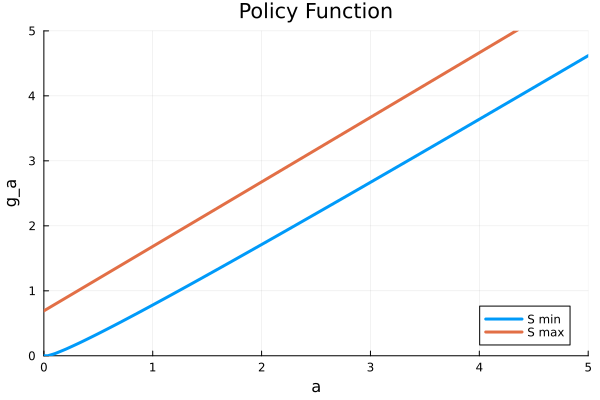

In [26]:
begin
	plot(gA, [decisions.ap[:,1] decisions.ap[:,nS]], label=["S min" "S max"], lw = 3, legend=:bottomright)
	title!("Policy Function")
	axis_lim = 5
	xlims!(0,axis_lim)
	ylims!(0,axis_lim)
	xlabel!("a")
	ylabel!("g_a")
end

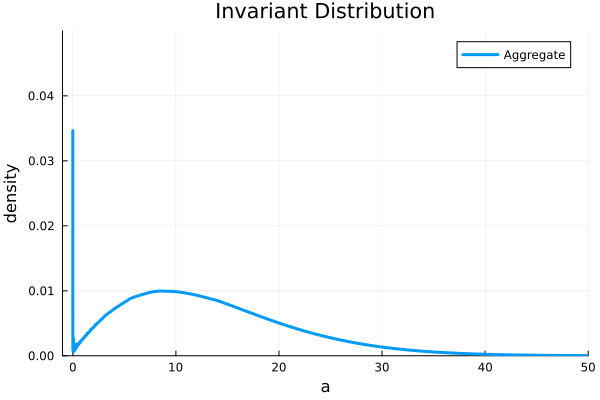

In [28]:
begin
	plot(param.gA, asset_distribution, label="Aggregate", lw = 3)
	title!("Invariant Distribution")
	xlims!(-1,50) # little mass over 50
	ylims!(0,0.05) # Ps the mass of constrained HH is about 20% of individuals in S)1
	xlabel!("a")
	ylabel!("density")
end

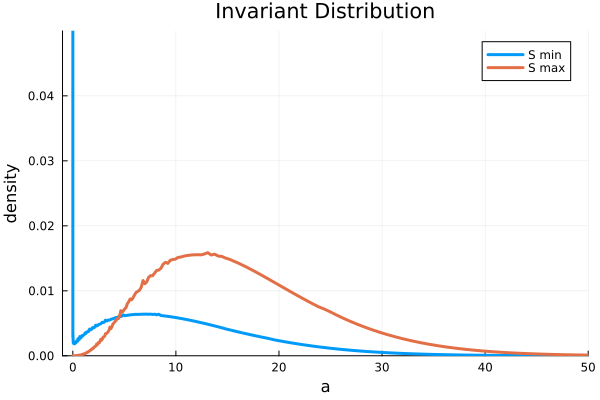

In [29]:
begin
	plot(param.gA, [dsn[:,1]./sum(dsn[:,1]) dsn[:,nS]./sum(dsn[:,nS])], label=["S min" "S max" ], lw = 3)
	title!("Invariant Distribution")
	xlims!(-1,50) # little mass over 50
	ylims!(0,0.05) # Ps the mass of constrained HH is about 20% of individuals in S)1
	xlabel!("a")
	ylabel!("density")
end